# Setting and download

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

######################################
import random

######################################
import os
import zipfile
import glob
#from pathlib import Path


######################################
import re, nltk, spacy



######################################
#from PIL import Image, ImageDraw
import matplotlib.image as mpimg


######################################
#import sklearn


######################################
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [5]:
#FOR COLAB
!gdown https://drive.google.com/uc?id=1UG1hY2lxBU62ouiY679972kohWAvOjRM
root_path = os.getcwd()
DATA_PATH = os.path.join(root_path, 'movie_data.csv')

Downloading...
From: https://drive.google.com/uc?id=1UG1hY2lxBU62ouiY679972kohWAvOjRM
To: /content/movie_data.csv
65.9MB [00:00, 128MB/s] 


In [3]:
# #FOR local computer
# DATA_PATH = 'movie_data.csv'

In [6]:
df = pd.read_csv(DATA_PATH) #, encoding='utf-8'

In [ ]:
# def stream_docs(path):
#     with open(path, 'r', encoding='utf-8') as csv:
#         next(csv)  # skip header
#         for line in csv:
#             text, label = line[:-3], int(line[-2])
#             yield text, label

# Overview 

In [7]:
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [8]:
df.shape

(50000, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [10]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [11]:
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

## Positive and negative reviews: Example and distribution

In [12]:
id_pos = (df['sentiment'] == 1)
df_pos = df[id_pos]
print('A positive review:')
df_pos.iloc[5, 0]

A positive review:


"I've been impressed with Chavez's stance against globalisation for sometime now, but it wasn't until I saw the film at the Amsterdam documentary international film festival that I realize what he has really achieved. This film tells the story of coup/conspiracy by Venezuela's elite, the oil companies and oil loving corrupt western governments, to remove democratically elected president Chavez, and return Venezuela back to a brutal dictatorship. This film is must for anyone who believes in freedom and justice, and is also a lesson to the rest of world ! I commend the people of Venezuela for taking matter into their own hands, and saving their country from the likes of Halliburton and the Bush regime."

In [15]:
df_neg = df[~id_pos]
print('A negative review:')
df_pos.iloc[101, 0]

A negative review:


'This is one of the creepiest, scariest and most heartbreaking horror movie EVER! <br /><br />Dr Creed (Louise) and his family moving in to new home with his wife (Rachel), Daughter (Ellie) and little son (Gage) Everything seems normal until Dr Creed loses one his patient who had a terrible head injury,Then he is haunted by the ghost know as Victor takes him to the Pet Sematarty and show him that where the dead come to life.<br /><br />Louis not knowing if that was all dream and is talking to Ellie who worried about her cat that could be killed by lorry and then later on Rachel tells Louis that it really hard for to talk about death because of her sister Zelda who was really sick (As we see in a flashback how sick her sister really was and this is one of the most creepiest scene ever!) <br /><br />The next day Louis gets a call from Jed saying there cat as been killed by lorry and Jed take him to place where Victor the Ghost told him not to go! And bury the Cat, His wife and kids have 

In [16]:
df['length_review'] = df['review'].map(len)

In [17]:
df.head()

,review,sentiment,length_review
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,1393
1,OK... so... I really like Kris Kristofferson a...,0,1257
2,"***SPOILER*** Do not read this, if you think a...",0,1678
3,hi for all the people who have seen this wonde...,1,381
4,"I recently bought the DVD, forgetting just how...",0,698


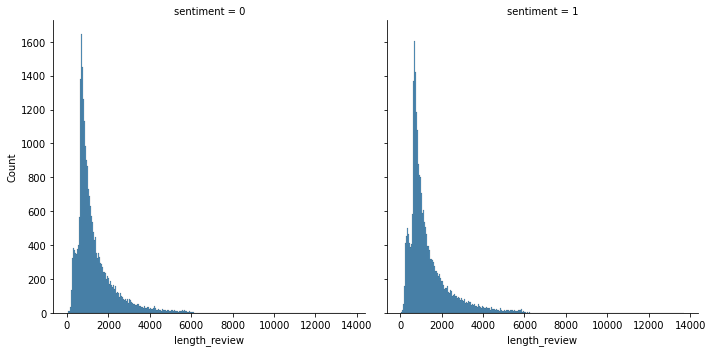

In [31]:
sns.displot(x = 'length_review', kind = 'hist', data= df, col = "sentiment")

# Clearning

In [32]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)  
    #Reomove all HTML markup, Advanced see html.parser in python
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) #List cac emoticons
    #text = (re.sub('[\W]+', ' ', text.lower()) +
    #        ' '.join(emoticons).replace('-', ''))
    text =  re.sub('[\W]+', ' ', text.lower()) 
    #loai bo cac ky tu khong la word, trong do co cac emotions
    text = text + ' '.join(emoticons).replace('-', '')#keep emotion o dang sau
    return text

In [33]:
preprocessor(df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [34]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [35]:
df['review'] = df['review'].apply(preprocessor)

# Split data

In [36]:
X_train = df.loc[:35000, 'review'].values
y_train = df.loc[:35000, 'sentiment'].values
X_test = df.loc[35000:, 'review'].values
y_test = df.loc[35000:, 'sentiment'].values

In [47]:
X_train[0]

'in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwich connecticut on the mischief night eve of halloween she was murdered in the backyard of her house and her murder remained unsolved twenty two years later the writer mark fuhrman christopher meloni who is a former la detective that has fallen in disgrace for perjury in o j simpson trial and moved to idaho decides to investigate the case with his partner stephen weeks andrew mitchell with the purpose of writing a book the locals squirm and do not welcome them but with the support of the retired detective steve carroll robert forster that was in charge of the investigation in the 70 s they discover the criminal and a net of power and money to cover the murder murder in greenwich is a good tv movie with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a kennedy the powerful and rich family used their influence to cover the mur

# Model

## Tokernizer

In [38]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Model architecture

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, ],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False], #BECOME NORMAL COUNTS
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, solver='liblinear'))])

gr_logreg_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

## Training and results

In [40]:
gr_logreg_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 14.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [42]:
print('Best parameter set: %s ' % gr_logreg_tfidf.best_params_)
print('CV Accuracy: %.3f' % gr_logreg_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7fcbaa351170>} 
CV Accuracy: 0.900


In [43]:
clf = gr_logreg_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.903


In [52]:
import pickle
dest = os.getcwd()
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

In [ ]:
##clf = pickle.load(open(os.path.join('classifier.pkl'),'rb'))

# @@Bag-of-words model@@

## Raw Tf

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()

## Tf-idf

In [ ]:
from sklearn.feature_extraction.text import Tfidfvectorizer
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs))
      .toarray())

## NLTK

In [ ]:
def my_tokenizer(text):
    """Clearning and tokernizer at the same time"""
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text =  re.sub('[\W]+', ' ', text.lower())
    text = text + ' '.join(emoticons).replace('-', '')

    #tokenized = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text.split() if w not in stop] 
    return tokenized

<br>
<br>